In [31]:
from pyspark.ml.feature import RegexTokenizer # tokenizer
from pyspark.ml.feature import HashingTF, IDF # vectorizer
from pyspark.ml.feature import StopWordsRemover # to remove stop words
from pyspark.sql.functions import col, concat_ws # to concatinate cols
from pyspark.sql import functions as F
from pyspark.ml.classification import LogisticRegression # ml model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # to evaluate the model
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import DoubleType
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("news-classification") \
    .getOrCreate()

/usr/local/spark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 15:01:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
train = spark.read.csv("data/train.csv", inferSchema=True, header=True)
test = spark.read.csv("data/test.csv", inferSchema=True, header=True)

In [4]:
train.printSchema()

root
 |-- Class Index: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Description: string (nullable = true)



In [5]:
#rename class index to label
train = train.withColumnRenamed("Class Index", "label")
test = test.withColumnRenamed("Class Index", "label")

In [6]:
train.printSchema()

root
 |-- label: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Description: string (nullable = true)



In [7]:
train.count()

120000

In [8]:
test.count()

7600

In [9]:
# Add a new column 'Text' by concatinating 'Title' and 'Description',
train = train.withColumn("Text", concat_ws(" ", "Title", 'Description'))
test = test.withColumn("Text", concat_ws(" ", "Title", 'Description'))

In [10]:
# Remove old text columns\n",
train = train.select('label', 'text')

In [11]:
# Remove old text columns\n",
test = test.select('label', 'text')

In [12]:
train.first()

Row(label=3, text="Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [13]:
test.first()

Row(label=3, text="Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.")

In [14]:
# convert sentences to list of words
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# adds a column 'words' to df after tokenization
train = tokenizer.transform(train)
test = tokenizer.transform(test)

train.select(['label','text', 'words']).show(5)

+-----+--------------------+--------------------+
|label|                text|               words|
+-----+--------------------+--------------------+
|    3|Wall St. Bears Cl...|[wall, st, bears,...|
|    3|Carlyle Looks Tow...|[carlyle, looks, ...|
|    3|Oil and Economy C...|[oil, and, econom...|
|    3|Iraq Halts Oil Ex...|[iraq, halts, oil...|
|    3|Oil prices soar t...|[oil, prices, soa...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [15]:
# to remove stop words like is, the, in, etc.
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# adds a column 'filtered' to df without stopwords
train = stopwords_remover.transform(train)
test = stopwords_remover.transform(test)

train.select(['label','text', 'words', 'filtered']).first()

Row(label=3, text="Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", words=['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 's', 'dwindling', 'band', 'of', 'ultra', 'cynics', 'are', 'seeing', 'green', 'again'], filtered=['wall', 'st', 'bears', 'claw', 'back', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 'dwindling', 'band', 'ultra', 'cynics', 'seeing', 'green'])

In [16]:
# Calculate term frequency in each article
hashing_tf = HashingTF(inputCol="filtered",
                       outputCol="raw_features", 
                       numFeatures=10000)

# adds raw tf features to train and test
featurized_data_train = hashing_tf.transform(train)
featurized_data_test = hashing_tf.transform(test)

In [17]:
featurized_data_train.first()

Row(label=3, text="Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", words=['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 's', 'dwindling', 'band', 'of', 'ultra', 'cynics', 'are', 'seeing', 'green', 'again'], filtered=['wall', 'st', 'bears', 'claw', 'back', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 'dwindling', 'band', 'ultra', 'cynics', 'seeing', 'green'], raw_features=SparseVector(10000, {551: 1.0, 662: 1.0, 1262: 1.0, 1449: 1.0, 1889: 1.0, 1948: 1.0, 2503: 1.0, 2826: 1.0, 3038: 1.0, 3684: 1.0, 4443: 1.0, 6404: 2.0, 8318: 1.0, 8430: 1.0, 8450: 2.0, 9430: 1.0}))

In [18]:
# Inverse document frequency
idf = IDF(inputCol="raw_features", outputCol="features")

idf_vectorizer = idf.fit(featurized_data_train)

# converting text to vectors
rescaled_data_train = idf_vectorizer.transform(featurized_data_train)
rescaled_data_test = idf_vectorizer.transform(featurized_data_test)

# show first row
rescaled_data_train.select("label",'Text', 'words', 'filtered', "features").first()

Row(label=3, Text="Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", words=['wall', 'st', 'bears', 'claw', 'back', 'into', 'the', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 's', 'dwindling', 'band', 'of', 'ultra', 'cynics', 'are', 'seeing', 'green', 'again'], filtered=['wall', 'st', 'bears', 'claw', 'back', 'black', 'reuters', 'reuters', 'short', 'sellers', 'wall', 'street', 'dwindling', 'band', 'ultra', 'cynics', 'seeing', 'green'], features=SparseVector(10000, {551: 5.0712, 662: 6.0219, 1262: 4.8128, 1449: 5.9301, 1889: 6.8511, 1948: 5.1091, 2503: 7.6177, 2826: 5.9301, 3038: 4.6094, 3684: 4.3538, 4443: 5.6646, 6404: 9.0673, 8318: 8.0064, 8430: 3.3834, 8450: 4.4483, 9430: 6.5595}))

In [19]:
# create model
lr = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial",
                        regParam=0.3,
                        elasticNetParam=0,
                        maxIter=50)

In [32]:
#looking for columns with null values in train df
rescaled_data_train.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in rescaled_data_train.columns]).show()

+-----+----+-----+--------+------------+--------+
|label|text|words|filtered|raw_features|features|
+-----+----+-----+--------+------------+--------+
|    0|   0|    0|       0|           0|       0|
+-----+----+-----+--------+------------+--------+



In [33]:
#looking for columns with null values in test df
rescaled_data_test.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in rescaled_data_test.columns]).show()

+-----+----+-----+--------+------------+--------+
|label|text|words|filtered|raw_features|features|
+-----+----+-----+--------+------------+--------+
|    0|   0|    0|       0|           0|       0|
+-----+----+-----+--------+------------+--------+



In [34]:
# fit model
lrModel = lr.fit(rescaled_data_train)

24/12/02 15:12:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [35]:
# get predictions for test set
predictions = lrModel.transform(rescaled_data_test)

In [36]:
# show top 10 predictions
predictions.select("Text", 'probability','prediction', 'label').show(5)

+--------------------+--------------------+----------+-----+
|                Text|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|Fears for T N pen...|[5.60449440390442...|       3.0|    3|
|The Race is On: S...|[1.14071490835005...|       4.0|    4|
|Ky. Company Wins ...|[6.54740968853534...|       4.0|    4|
|Prediction Unit H...|[7.45306676957384...|       2.0|    4|
|Calif. Aims to Li...|[6.27946230614665...|       4.0|    4|
+--------------------+--------------------+----------+-----+
only showing top 5 rows



In [37]:
#accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
#accuracy in percentage
accuracy = evaluator.evaluate(predictions)*100
print("Accuracy: " + str(accuracy.__round__(2)) + "%")

Accuracy: 89.75%


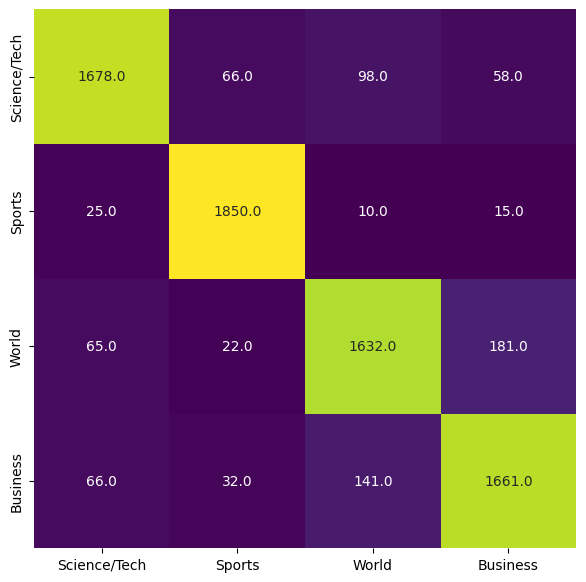

In [42]:
labels = {"World","Sports","Business", "Science/Tech"}

preds_and_labels = preds_and_labels.withColumn('prediction', col('prediction').cast('double')) \
                                   .withColumn('label', col('label').cast('double'))

preds_and_labels_rdd = preds_and_labels.rdd.map(lambda row: (row['prediction'], row['label']))

# generate metrics
metrics = MulticlassMetrics(preds_and_labels_rdd)

# figure object
_ = plt.figure(figsize=(7, 7))

# plot confusion matrix
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.show()

In [43]:
#save the model
lrModel.write().overwrite().save("./lrModel")

In [ ]:
# save vectorizer
idf_vectorizer.save("./idfModel")  
hashing_tf.save("./hashingTF")